# Dataset Classification
- This notebook has the objective to test the classification of the dataset
  - Uses the datase with only 80% of samples, stores 20% samples for later
  - Two class classification: Transforms the dataset to have only two classes


# Setup

- Set to `true` if runnig in Colab

In [1]:
RUNNING_IN_COLAB = True

- Import google drive

In [2]:
if RUNNING_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import python modules

In [3]:
import time
import pickle
import joblib
import os
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns  


from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Hardware Information

In [4]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   38G   70G  36% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  812M  59% /sbin/docker-init
tmpfs           6.4G   32K  6.4G   1% /var/colab
/dev/sda1        81G   42G   40G  52% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   12G  3.5G  77% /content/drive


In [5]:
!cat /proc/meminfo

MemTotal:       13298580 kB
MemFree:         9806176 kB
MemAvailable:   11727620 kB
Buffers:          109804 kB
Cached:          1902116 kB
SwapCached:            0 kB
Active:          1800892 kB
Inactive:        1473412 kB
Active(anon):    1156228 kB
Inactive(anon):      476 kB
Active(file):     644664 kB
Inactive(file):  1472936 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              2852 kB
Writeback:             0 kB
AnonPages:       1262288 kB
Mapped:           309112 kB
Shmem:              1200 kB
KReclaimable:      90588 kB
Slab:             137088 kB
SReclaimable:      90588 kB
SUnreclaim:        46500 kB
KernelStack:        6080 kB
PageTables:        18016 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649288 kB
Committed_AS:    3709140 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        8584 kB
VmallocChunk:          0 kB
Percpu:          

In [6]:
!cat /proc/cpuinfo  | grep "model name"

model name	: AMD EPYC 7B12
model name	: AMD EPYC 7B12


In [7]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [8]:
!lscpu 

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               49
Model name:          AMD EPYC 7B12
Stepping:            0
CPU MHz:             2250.000
BogoMIPS:            4500.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            16384K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignss

In [9]:
!free -h | grep Mem:

Mem:            12G        1.3G        9.3G        1.2M        2.0G         11G


# Preparing Dataset

## Reading dataset CSV (File with only 80% if the samples)

In [10]:
if RUNNING_IN_COLAB:
    CSV_PATH = '/content/drive/My Drive/Colab Notebooks/DataScience/All_Infogain_80.csv'
    SAVED_MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/'
    IMAGES_PATH = '/content/drive/My Drive/Colab Notebooks/DataScience/images/'
else:   
    CSV_PATH = '../../dataset/FinalDataset/All_Infogain_80.csv'
    SAVED_MODEL_PATH = '../data'
    IMAGES_PATH = '../results'

df = pd.read_csv(CSV_PATH)
df.dropna(inplace=True)
df.head()

,avgpathtokenlen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,CharacterContinuityRate,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath,Entropy_Domain,class
0,5.133,0.827,0.018,0.167,0.109,7.583,0.022,0.750,0.091,0.000,-1.0,1.000,benign
1,10.250,0.625,0.028,0.100,0.278,2.250,0.044,0.350,0.306,0.688,-1.0,0.852,phishing
2,3.467,0.778,0.101,0.667,0.152,5.133,0.130,0.733,0.152,-1.000,0.4,0.770,malware
3,4.857,0.520,0.026,0.067,0.390,1.333,0.050,0.900,0.000,0.000,-1.0,0.775,malware
4,3.200,0.738,0.488,2.733,0.179,4.133,0.661,0.533,0.048,0.000,0.0,0.817,malware


## Drop Problematic Features
- These features were not given a propper explanation on how to calculate them

In [11]:
df = df.drop(['Entropy_Domain', 'CharacterContinuityRate', 'avgpathtokenlen'], axis=1)
df.head()

,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath,class
0,0.827,0.018,0.167,0.109,7.583,0.022,0.091,0.000,-1.0,benign
1,0.625,0.028,0.100,0.278,2.250,0.044,0.306,0.688,-1.0,phishing
2,0.778,0.101,0.667,0.152,5.133,0.130,0.152,-1.000,0.4,malware
3,0.520,0.026,0.067,0.390,1.333,0.050,0.000,0.000,-1.0,malware
4,0.738,0.488,2.733,0.179,4.133,0.661,0.048,0.000,0.0,malware


## Generates dataset with only 'positive' and 'negative' classes (Two-class classification)
- Replaces the classes: 'spam', 'phishing', 'Defacemente' and 'malware' with 'malicious'
- Two classes: 'benign' and 'malicious'

In [12]:
df_positive = df.copy()

df_positve = df_positive.loc[ df_positive['class'] == 'phishing', 'class'] = 'malicious'
df_positve = df_positive.loc[ df_positive['class'] == 'malware', 'class'] = 'malicious'
df_positve = df_positive.loc[ df_positive['class'] == 'spam', 'class'] = 'malicious'
df_positve = df_positive.loc[ df_positive['class'] == 'Defacement', 'class'] = 'malicious'

class_counts = df_positive['class'].value_counts()
print(class_counts)

df_positive.head()

malicious    22899
benign        6234
Name: class, dtype: int64


,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath,class
0,0.827,0.018,0.167,0.109,7.583,0.022,0.091,0.000,-1.0,benign
1,0.625,0.028,0.100,0.278,2.250,0.044,0.306,0.688,-1.0,malicious
2,0.778,0.101,0.667,0.152,5.133,0.130,0.152,-1.000,0.4,malicious
3,0.520,0.026,0.067,0.390,1.333,0.050,0.000,0.000,-1.0,malicious
4,0.738,0.488,2.733,0.179,4.133,0.661,0.048,0.000,0.0,malicious


## See distrubution of classes

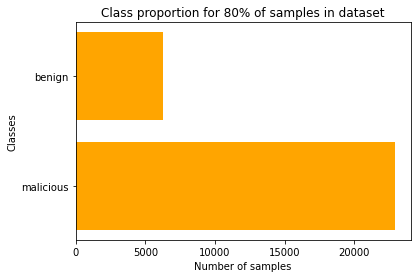

In [13]:
#Plot bar graph to show class sample distribution
plt.title("Class proportion for 80% of samples in dataset")
plt.ylabel('Classes')
plt.xlabel('Number of samples') 
plt.barh(class_counts.index, class_counts, color='orange')

plt.savefig(os.path.join(IMAGES_PATH, 'bin_class_dist.png'))
plt.show()

## Split data into X and Y

In [14]:
#X is a matrix, with all the samples feature array
X = df_positive.iloc[:, :-1].values
print(X, '\n')

#Y is the class of the samples
Y = df_positive.iloc[:, -1].values
print(Y)

[[ 0.827  0.018  0.167 ...  0.091  0.    -1.   ]
 [ 0.625  0.028  0.1   ...  0.306  0.688 -1.   ]
 [ 0.778  0.101  0.667 ...  0.152 -1.     0.4  ]
 ...
 [ 0.784  0.642  3.909 ...  0.216  0.295  0.326]
 [ 0.442  0.154  0.364 ...  0.077  0.182  0.5  ]
 [ 0.146  0.049  0.071 ...  0.     0.    -1.   ]] 

['benign' 'malicious' 'malicious' ... 'malicious' 'malicious' 'malicious']


# GridSearch - Finding Best hyper-parameters for each classifier
- Classifiers: KNN, RandomForest and MLP
- Parameters: (k = 1, 3, 5). (trees = 50, 100); (epocs = 1000, 5000)
- Evaluation Metric: `recall` (low FN, avoid classifing a malicious URL as benign


In [15]:
evaluation_metric = 'recall_macro'

## KNN 


In [16]:
gs = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid={'n_neighbors':[1, 3, 5]},
    scoring=evaluation_metric,
    refit=evaluation_metric
)

gs.fit(X, Y)
k = gs.best_params_['n_neighbors']
print(gs.best_estimator_)
print(gs.best_score_)
print("Best K:", k)

KNeighborsClassifier(n_neighbors=1)
0.8967506835891944
Best K: 1


## RandomForest


In [17]:
gs = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid={'n_estimators':[50, 100], 'random_state': [5]},
    scoring=evaluation_metric,
    refit=evaluation_metric
)

gs.fit(X, Y)
n_trees = gs.best_params_['n_estimators']
print(gs.best_estimator_)
print(gs.best_score_)
print("Best n_trees:", n_trees)

RandomForestClassifier(n_estimators=50, random_state=5)
0.9328934707644783
Best n_trees: 50


## MLP

In [18]:
gs = GridSearchCV(
    estimator=MLPClassifier(), 
    param_grid={'max_iter':[1000, 5000], 'random_state': [5]},
    scoring=evaluation_metric,
    refit=evaluation_metric
)

gs.fit(X, Y)
epocs = gs.best_params_['max_iter']
print(gs.best_estimator_)
print(gs.best_score_)
print("Best epocs:", epocs)

MLPClassifier(max_iter=1000, random_state=5)
0.8513734548086107
Best epocs: 1000


# Classification - Using best hyper-parameters for each classifier
- Using train/test split with:
  - 80/20
  - 50/50
  - K-fold (k=5)

### Helper functions

- Function to plot confusion matrix graph

In [19]:
def confusion_matrix_grap(cm, title="Confusion_matrix", save=True):
  """
  Plots a graph with the results of a confusion matrix
  :param matrix cm: The confusion matrix
  :param str title: The title for the grap
  """

  #Plot confusion matrix
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g' ,ax=ax) #annot=True to annotate cells, ftm='g' to disable scientific notation   

  # labels, title and ticks
  ax.set_title(title, fontsize=20)
  ax.set_xlabel('Predicted labels', fontsize=20)
  ax.set_ylabel('True labels', fontsize=20)

  class_labels =['benign (neg)', 'malicious (pos)']

  ax.xaxis.set_ticklabels(class_labels, fontsize=10)
  ax.yaxis.set_ticklabels(class_labels, fontsize=10)

  plt.gcf().set_size_inches(10, 5)
  if save:
    filename = f"{title}.png".replace('/', '_').replace(',', '')
    plt.savefig(os.path.join(IMAGES_PATH, filename))
  plt.show()

- Function to plot ROC curve

In [20]:
def plot_roc_curve(fpr, tpr, label=None, title='ROC Curve'):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    #plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='best')
    plt.show()

- Functions to save/load machine learning model

In [21]:
def save_model(model, model_name, path):
  """
  Saves a machine learning model in the desired path
  :param model: A sklearn classifier fited to a given dataset
  :param str model_name: the model name
  :param str path: the path to save the model
  """
  # save the model to disk
  filename = f"{model_name}.sav"
  filepath = os.path.join(path, filename)

  #Create file if it does not exists
  if not os.path.exists(filepath):
      with open(filepath, 'w'): pass

  #dump model
  joblib.dump(model, filepath)

def load_model(model_name, path):
  """
  Returns a loaded machine learning model in the desired path
  :param str model_name: the model name
  :param str path: the path to save the model
  """
  # load the model from disk
  filename = f"{model_name}.sav"
  filepath = os.path.join(path, filename)
  loaded_model = joblib.load(filepath)
  return loaded_model


- Function to do classification and store metrics

In [22]:
def generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test):
  """
  Classifies a model and saves in a dict
  """
  #fit and measure execution time
  start_time = time.time()
  classifier.fit(X_train, Y_train)
  end_time = time.time()

  #save the model for later
  save_model(
      model=classifier,
      model_name=model_name,
      path=SAVED_MODEL_PATH
  )

  #Prediction and metrics
  Y_pred = classifier.predict(X_test)
  Y_scores = classifier.predict_proba(X_test)[:, 1]

  # for classifiers with decision_function, this achieves similar results
  # y_scores = classifier.decision_function(X_test)

  report = classification_report(Y_test, Y_pred, output_dict=True)
  cm = confusion_matrix(Y_test, Y_pred, labels=['benign', 'malicious'])

  fpr, tpr, auc_thresholds = roc_curve(Y_test, Y_scores, pos_label='malicious')
  
  result = {
    'classification_report': report,
    'confusion_matrix': cm.tolist(),
    'fit_time': end_time - start_time,
    'roc_curve': {
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc(fpr, tpr)
    }
  }

  print(classification_report(Y_test, Y_pred))
  return result

### Model dict to store confusion matrix and report for later

In [23]:
model_dict = {}

### KNN

- 80/20

              precision    recall  f1-score   support

      benign       0.84      0.84      0.84      1251
   malicious       0.96      0.96      0.96      4576

    accuracy                           0.93      5827
   macro avg       0.90      0.90      0.90      5827
weighted avg       0.93      0.93      0.93      5827

Fit Time: 0.0439605712890625 seconds



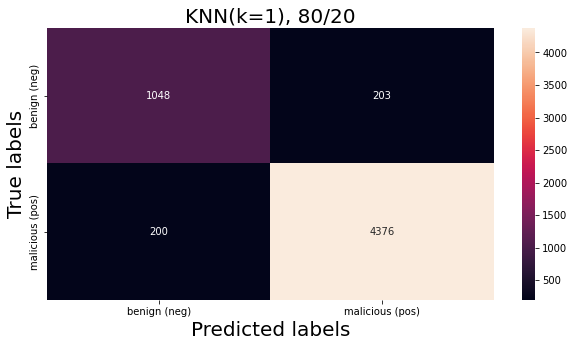

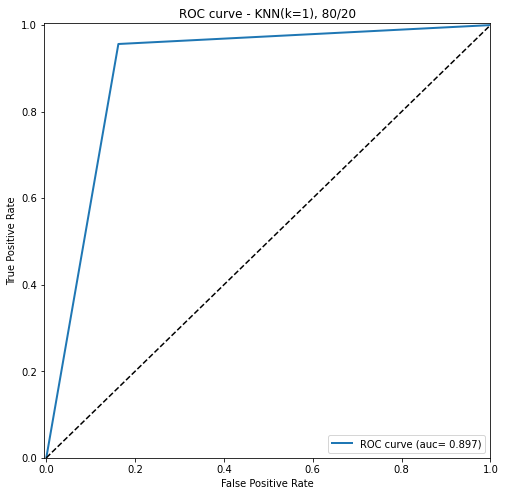

In [24]:
model_name = f"knn_{k}_80_20"
title = f"KNN(k={k}), 80/20"
classifier =  KNeighborsClassifier(n_neighbors=k)
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y, test_size=0.2, random_state=5)

result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
model_dict[model_name] = result
model_dict[model_name]['title'] = title

print("Fit Time:", result['fit_time'], 'seconds\n')

confusion_matrix_grap(
    cm=result['confusion_matrix'], 
    title=title
)

plot_roc_curve(
    fpr=result['roc_curve']['fpr'],
    tpr=result['roc_curve']['tpr'],
    label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
    title=f"ROC curve - {title}"
)

- 50/50

              precision    recall  f1-score   support

      benign       0.83      0.81      0.82      3122
   malicious       0.95      0.95      0.95     11445

    accuracy                           0.92     14567
   macro avg       0.89      0.88      0.88     14567
weighted avg       0.92      0.92      0.92     14567

Fit Time: 0.026627540588378906 seconds



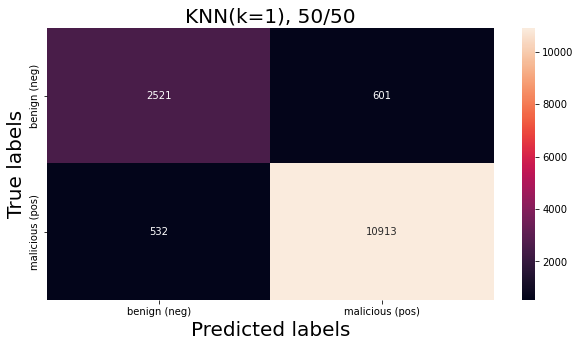

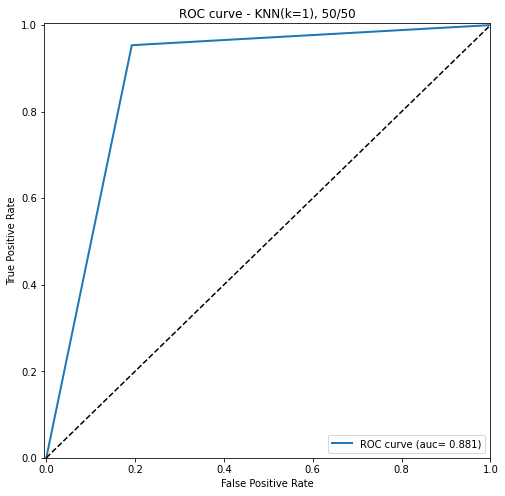

In [25]:
model_name = f"knn_{k}_50_50"
title = f"KNN(k={k}), 50/50"
classifier =  KNeighborsClassifier(n_neighbors=k)
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y, test_size=0.5, random_state=5)

result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
model_dict[model_name] = result
model_dict[model_name]['title'] = title

print("Fit Time:", result['fit_time'], 'seconds\n')

confusion_matrix_grap(
    cm=result['confusion_matrix'], 
    title=title
)

plot_roc_curve(
    fpr=result['roc_curve']['fpr'],
    tpr=result['roc_curve']['tpr'],
    label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
    title=f"ROC curve - {title}"
)

- K-fold (k=5)

              precision    recall  f1-score   support

      benign       0.83      0.84      0.84      1212
   malicious       0.96      0.95      0.96      4615

    accuracy                           0.93      5827
   macro avg       0.89      0.90      0.90      5827
weighted avg       0.93      0.93      0.93      5827

Fit Time: 0.049317359924316406 seconds



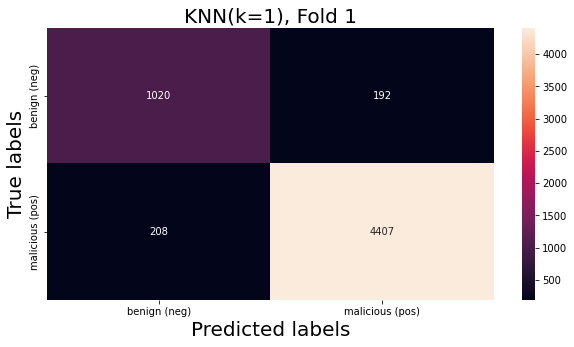

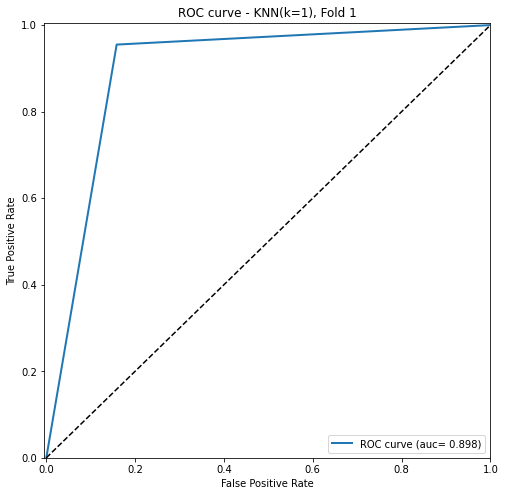

              precision    recall  f1-score   support

      benign       0.86      0.85      0.85      1280
   malicious       0.96      0.96      0.96      4547

    accuracy                           0.94      5827
   macro avg       0.91      0.90      0.90      5827
weighted avg       0.93      0.94      0.93      5827

Fit Time: 0.055274009704589844 seconds



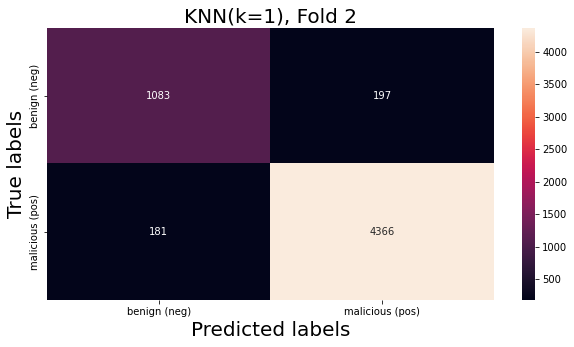

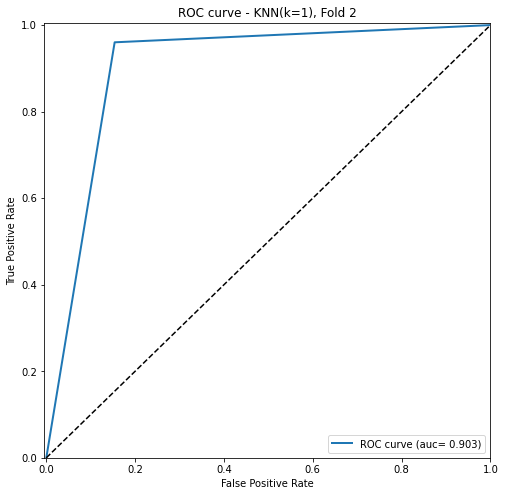

              precision    recall  f1-score   support

      benign       0.84      0.82      0.83      1261
   malicious       0.95      0.96      0.95      4566

    accuracy                           0.93      5827
   macro avg       0.89      0.89      0.89      5827
weighted avg       0.93      0.93      0.93      5827

Fit Time: 0.048657894134521484 seconds



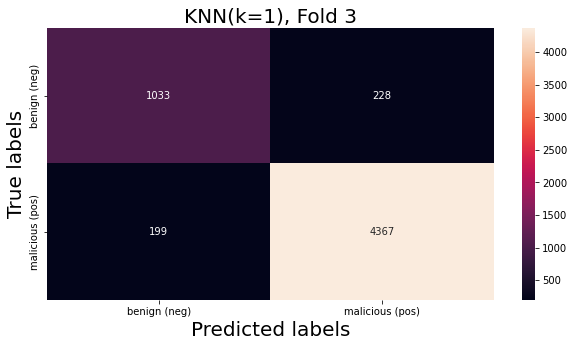

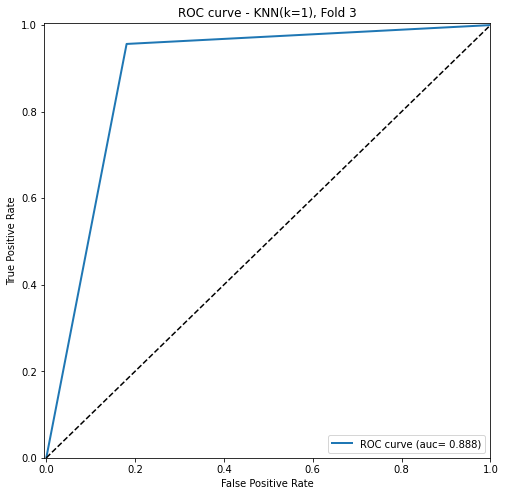

              precision    recall  f1-score   support

      benign       0.83      0.84      0.83      1238
   malicious       0.96      0.95      0.95      4588

    accuracy                           0.93      5826
   macro avg       0.89      0.89      0.89      5826
weighted avg       0.93      0.93      0.93      5826

Fit Time: 0.05001354217529297 seconds



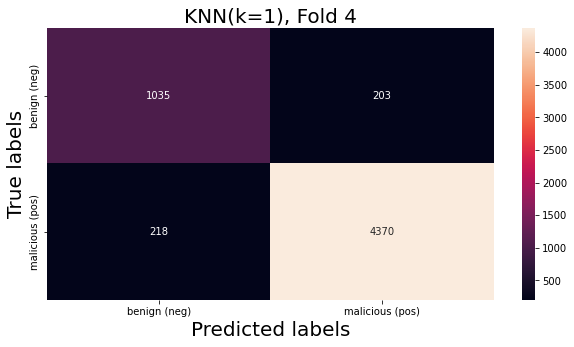

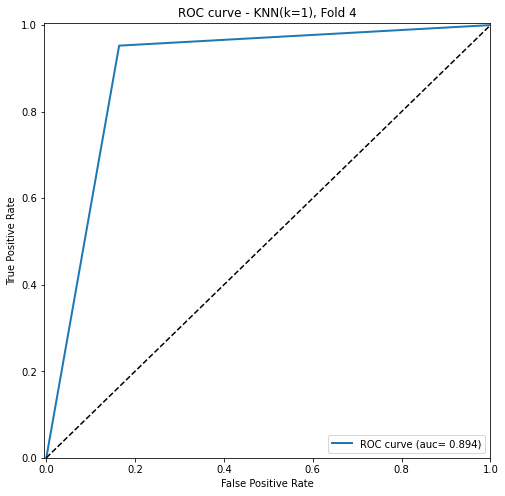

              precision    recall  f1-score   support

      benign       0.84      0.85      0.84      1243
   malicious       0.96      0.96      0.96      4583

    accuracy                           0.93      5826
   macro avg       0.90      0.90      0.90      5826
weighted avg       0.93      0.93      0.93      5826

Fit Time: 0.050551652908325195 seconds



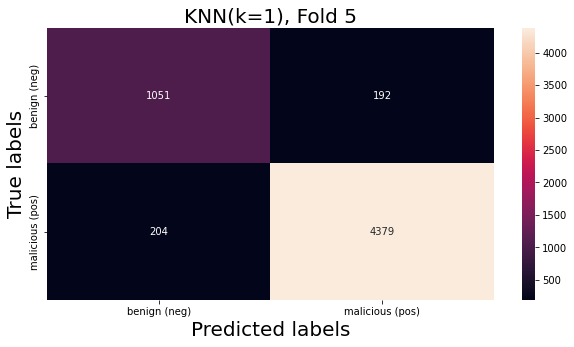

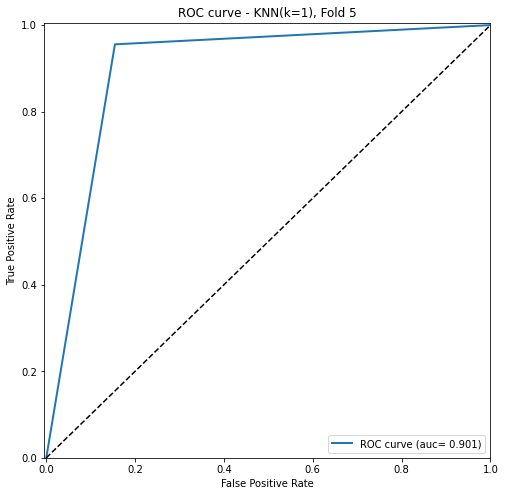

In [26]:
kf = KFold(n_splits=5)
i = 1

for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]
  Y_train, Y_test = Y[train_index], Y[test_index]

  model_name = f"knn_{k}_fold_{i}"
  title = f"KNN(k={k}), Fold {i}"
  classifier =  KNeighborsClassifier(n_neighbors=k)

  result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
  model_dict[model_name] = result
  model_dict[model_name]['title'] = title
  
  print("Fit Time:", result['fit_time'], 'seconds\n')
  confusion_matrix_grap(
    cm=result['confusion_matrix'], 
    title=title
  )

  plot_roc_curve(
      fpr=result['roc_curve']['fpr'],
      tpr=result['roc_curve']['tpr'],
      label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
      title=f"ROC curve - {title}"
  )
  i +=1

### RandomForest

- 80/20

              precision    recall  f1-score   support

      benign       0.90      0.88      0.89      1251
   malicious       0.97      0.97      0.97      4576

    accuracy                           0.95      5827
   macro avg       0.93      0.93      0.93      5827
weighted avg       0.95      0.95      0.95      5827

Fit Time: 1.3552629947662354 seconds



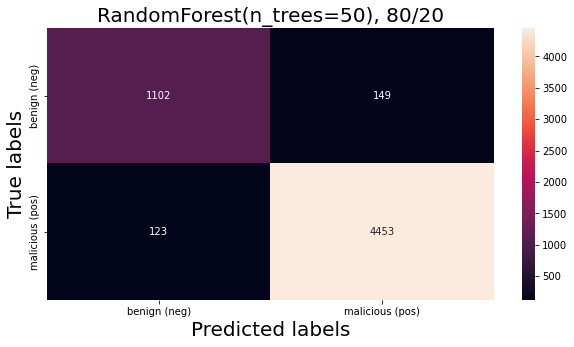

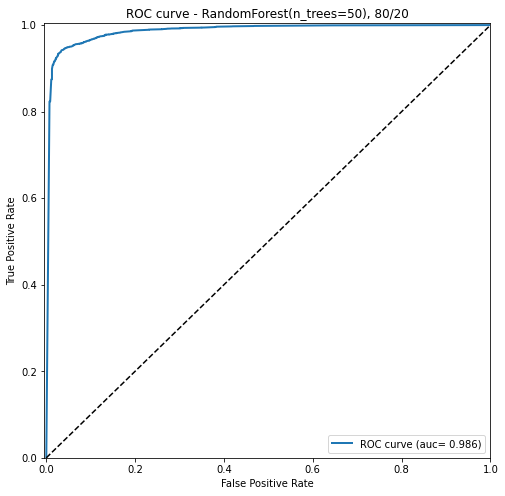

In [27]:
model_name = f"rf_{n_trees}_80_20"
title = f"RandomForest(n_trees={n_trees}), 80/20"
classifier =  RandomForestClassifier(n_estimators=n_trees)
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y, test_size=0.2, random_state=5)

result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
model_dict[model_name] = result
model_dict[model_name]['title'] = title

print("Fit Time:", result['fit_time'], 'seconds\n')
confusion_matrix_grap(
  cm=result['confusion_matrix'], 
  title=title
)

plot_roc_curve(
    fpr=result['roc_curve']['fpr'],
    tpr=result['roc_curve']['tpr'],
    label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
    title=f"ROC curve - {title}"
)

- 50/50

              precision    recall  f1-score   support

      benign       0.89      0.88      0.88      3122
   malicious       0.97      0.97      0.97     11445

    accuracy                           0.95     14567
   macro avg       0.93      0.92      0.93     14567
weighted avg       0.95      0.95      0.95     14567

Fit Time: 0.8426487445831299 seconds



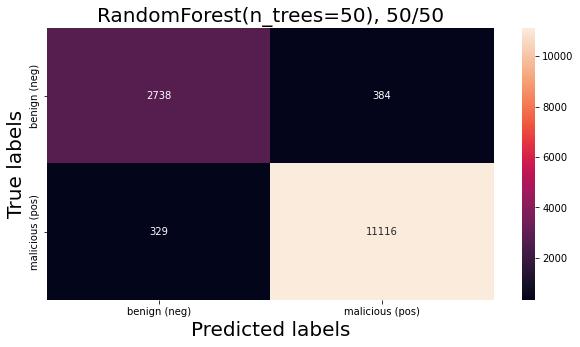

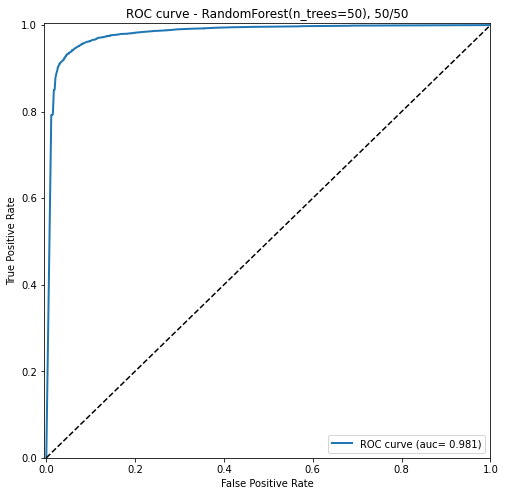

In [28]:
model_name = f"rf_{n_trees}_50_50"
title = f"RandomForest(n_trees={n_trees}), 50/50"
classifier =  RandomForestClassifier(n_estimators=n_trees)
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y, test_size=0.5, random_state=5)

result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
model_dict[model_name] = result
model_dict[model_name]['title'] = title

print("Fit Time:", result['fit_time'], 'seconds\n')
confusion_matrix_grap(
  cm=result['confusion_matrix'], 
  title=title
)

plot_roc_curve(
    fpr=result['roc_curve']['fpr'],
    tpr=result['roc_curve']['tpr'],
    label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
    title=f"ROC curve - {title}"
)

- K-fold (k=5)

              precision    recall  f1-score   support

      benign       0.90      0.89      0.90      1212
   malicious       0.97      0.97      0.97      4615

    accuracy                           0.96      5827
   macro avg       0.94      0.93      0.93      5827
weighted avg       0.96      0.96      0.96      5827

Fit Time: 1.3341193199157715 seconds



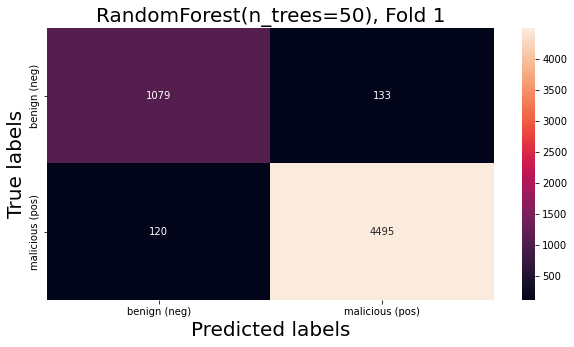

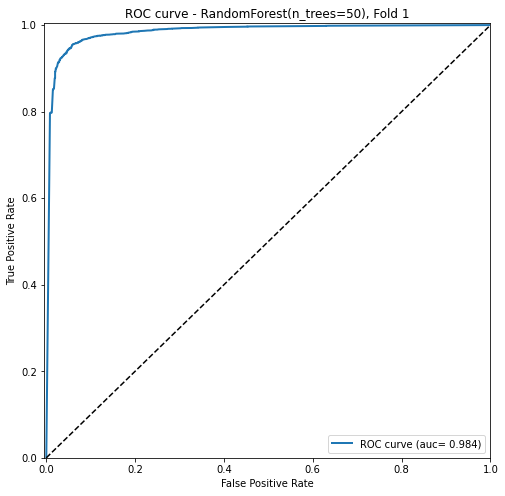

              precision    recall  f1-score   support

      benign       0.91      0.90      0.90      1280
   malicious       0.97      0.98      0.97      4547

    accuracy                           0.96      5827
   macro avg       0.94      0.94      0.94      5827
weighted avg       0.96      0.96      0.96      5827

Fit Time: 1.386448621749878 seconds



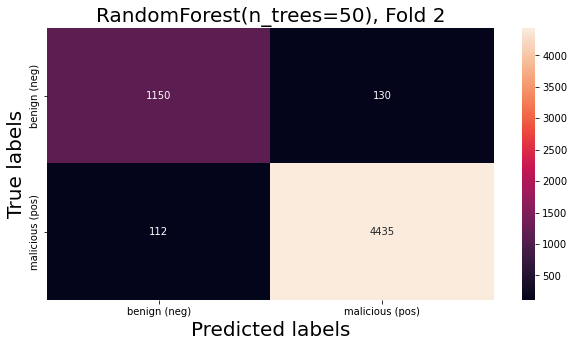

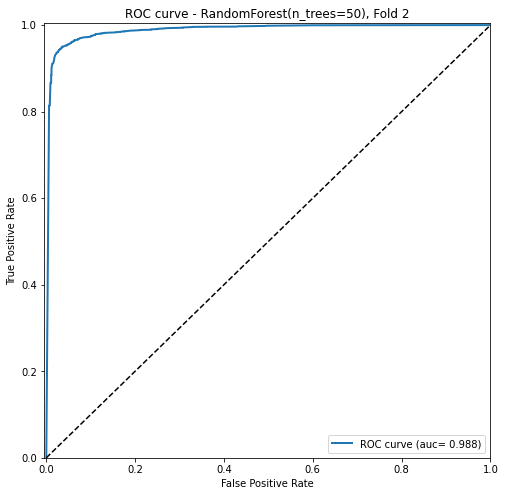

              precision    recall  f1-score   support

      benign       0.90      0.89      0.90      1261
   malicious       0.97      0.97      0.97      4566

    accuracy                           0.96      5827
   macro avg       0.94      0.93      0.93      5827
weighted avg       0.96      0.96      0.96      5827

Fit Time: 1.3370931148529053 seconds



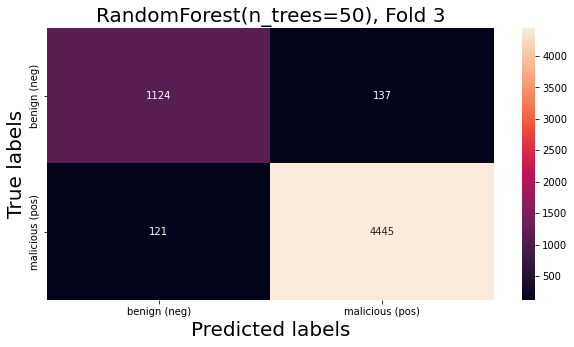

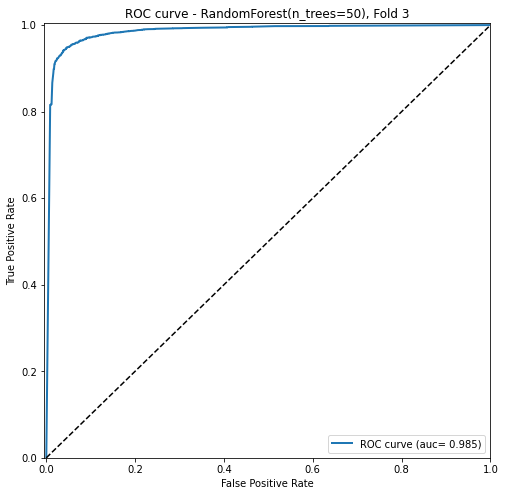

              precision    recall  f1-score   support

      benign       0.88      0.88      0.88      1238
   malicious       0.97      0.97      0.97      4588

    accuracy                           0.95      5826
   macro avg       0.93      0.93      0.93      5826
weighted avg       0.95      0.95      0.95      5826

Fit Time: 1.3444523811340332 seconds



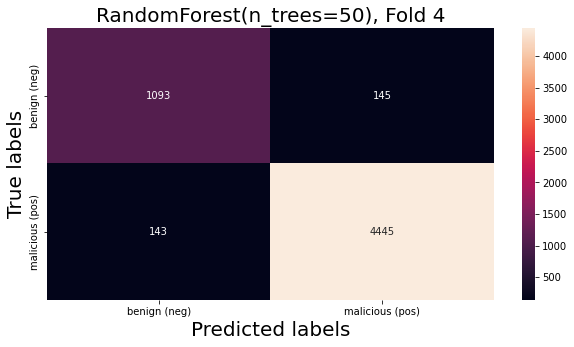

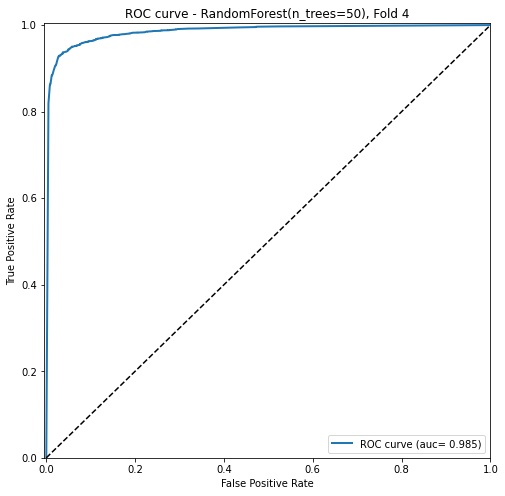

              precision    recall  f1-score   support

      benign       0.89      0.90      0.90      1243
   malicious       0.97      0.97      0.97      4583

    accuracy                           0.96      5826
   macro avg       0.93      0.93      0.93      5826
weighted avg       0.96      0.96      0.96      5826

Fit Time: 1.3468215465545654 seconds



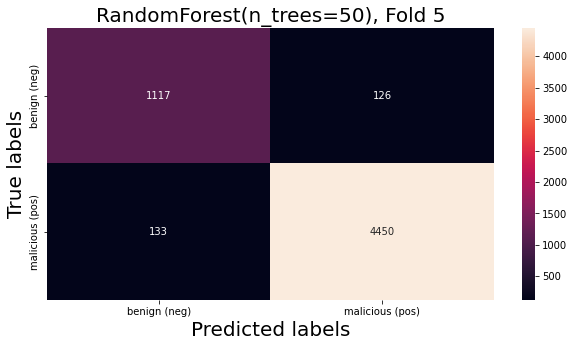

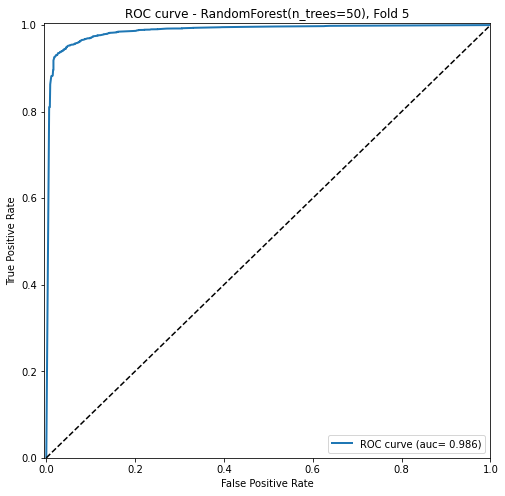

In [29]:
kf = KFold(n_splits=5)
i = 1

for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]
  Y_train, Y_test = Y[train_index], Y[test_index]

  model_name = f"rf_{n_trees}_fold_{i}"
  title = f"RandomForest(n_trees={n_trees}), Fold {i}"
  classifier =  RandomForestClassifier(n_estimators=n_trees)

  result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
  model_dict[model_name] = result
  model_dict[model_name]['title'] = title

  print("Fit Time:", result['fit_time'], 'seconds\n')
  confusion_matrix_grap(
    cm=result['confusion_matrix'], 
    title=title
  )

  plot_roc_curve(
      fpr=result['roc_curve']['fpr'],
      tpr=result['roc_curve']['tpr'],
      label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
      title=f"ROC curve - {title}"
  )
  i +=1

## MLP

- 80/20

              precision    recall  f1-score   support

      benign       0.76      0.71      0.73      1251
   malicious       0.92      0.94      0.93      4576

    accuracy                           0.89      5827
   macro avg       0.84      0.82      0.83      5827
weighted avg       0.89      0.89      0.89      5827

Fit Time: 22.90872573852539 seconds



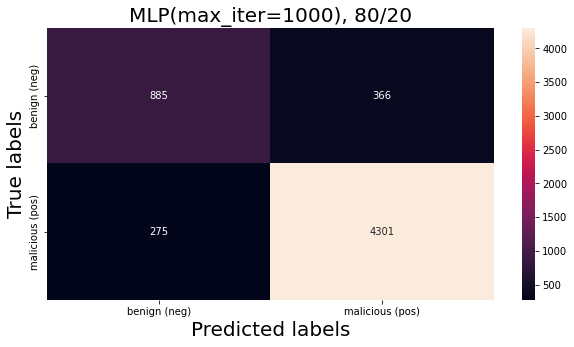

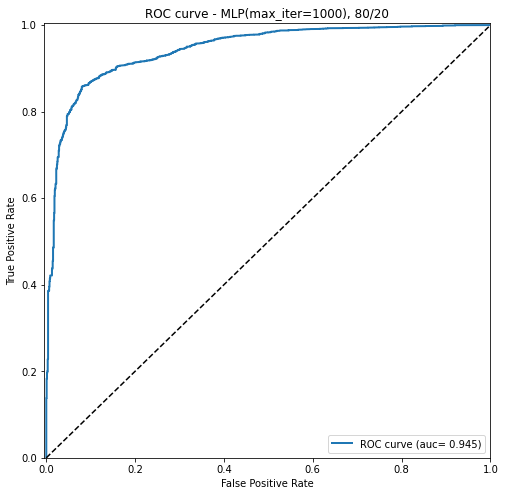

In [30]:
model_name = f"mlp_{epocs}_80_20"
title = f"MLP(max_iter={epocs}), 80/20"
classifier = MLPClassifier(random_state=5, max_iter=epocs)
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y, test_size=0.2, random_state=5)


result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
model_dict[model_name] = result
model_dict[model_name]['title'] = title

print("Fit Time:", result['fit_time'], 'seconds\n')
confusion_matrix_grap(
  cm=result['confusion_matrix'], 
  title=title
)

plot_roc_curve(
    fpr=result['roc_curve']['fpr'],
    tpr=result['roc_curve']['tpr'],
    label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
    title=f"ROC curve - {title}"
)

- 50/50

              precision    recall  f1-score   support

      benign       0.76      0.71      0.74      3122
   malicious       0.92      0.94      0.93     11445

    accuracy                           0.89     14567
   macro avg       0.84      0.83      0.83     14567
weighted avg       0.89      0.89      0.89     14567

Fit Time: 17.382035970687866 seconds



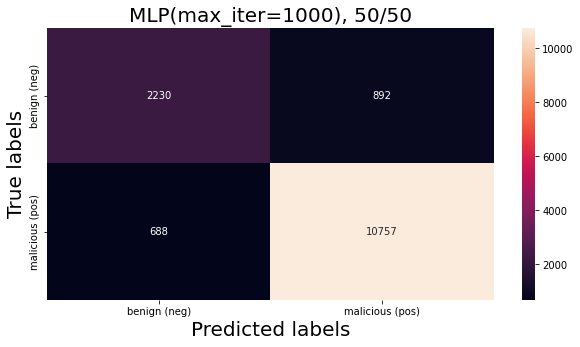

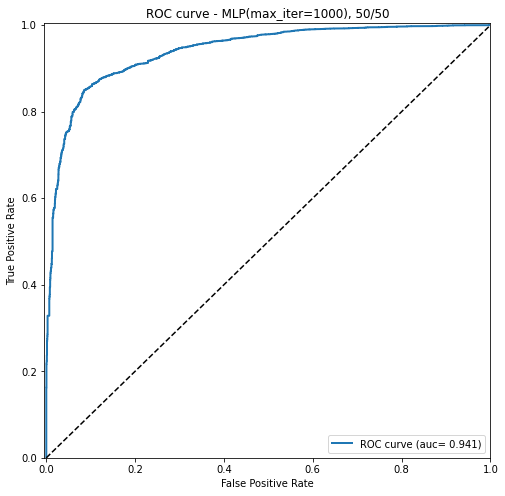

In [31]:
model_name = f"mlp_{epocs}_50_50"
title = f"MLP(max_iter={epocs}), 50/50"
classifier = MLPClassifier(random_state=5, max_iter=epocs)
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y, test_size=0.5, random_state=5)

result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
model_dict[model_name] = result
model_dict[model_name]['title'] = title

print("Fit Time:", result['fit_time'], 'seconds\n')
confusion_matrix_grap(
  cm=result['confusion_matrix'], 
  title=title
)

plot_roc_curve(
    fpr=result['roc_curve']['fpr'],
    tpr=result['roc_curve']['tpr'],
    label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
    title=f"ROC curve - {title}"
)

- K-fold (k=5)

              precision    recall  f1-score   support

      benign       0.79      0.71      0.75      1212
   malicious       0.93      0.95      0.94      4615

    accuracy                           0.90      5827
   macro avg       0.86      0.83      0.84      5827
weighted avg       0.90      0.90      0.90      5827

Fit Time: 31.12394690513611 seconds



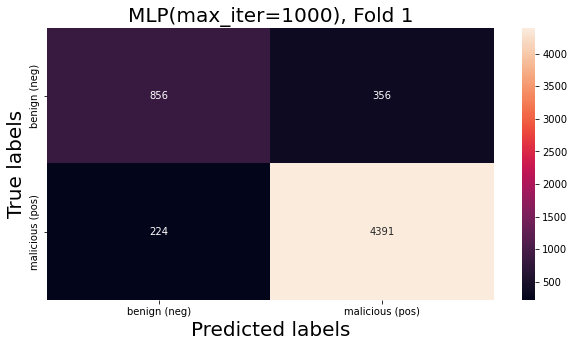

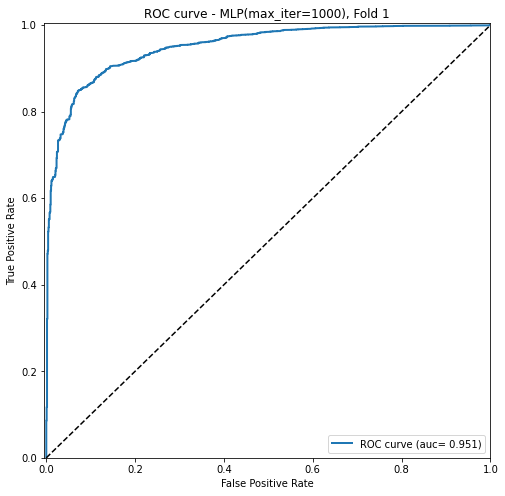

              precision    recall  f1-score   support

      benign       0.76      0.81      0.79      1280
   malicious       0.95      0.93      0.94      4547

    accuracy                           0.90      5827
   macro avg       0.85      0.87      0.86      5827
weighted avg       0.91      0.90      0.90      5827

Fit Time: 37.12113380432129 seconds



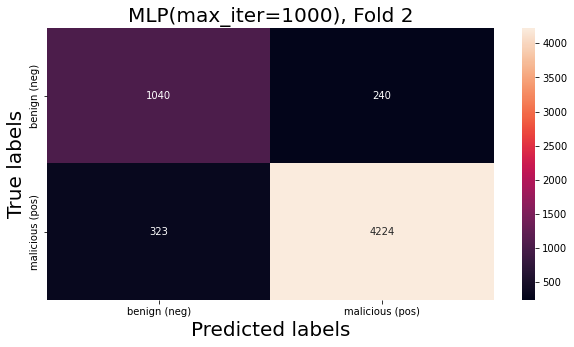

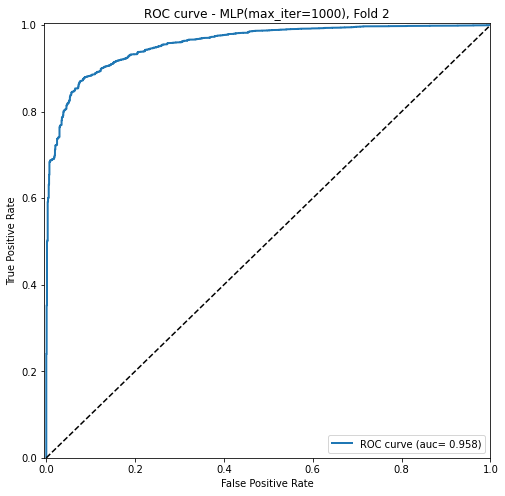

              precision    recall  f1-score   support

      benign       0.69      0.87      0.77      1261
   malicious       0.96      0.89      0.93      4566

    accuracy                           0.89      5827
   macro avg       0.83      0.88      0.85      5827
weighted avg       0.90      0.89      0.89      5827

Fit Time: 32.187398195266724 seconds



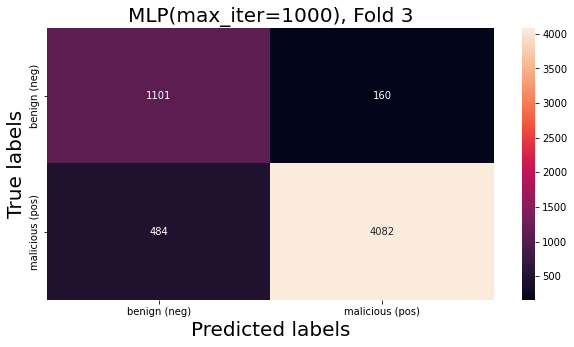

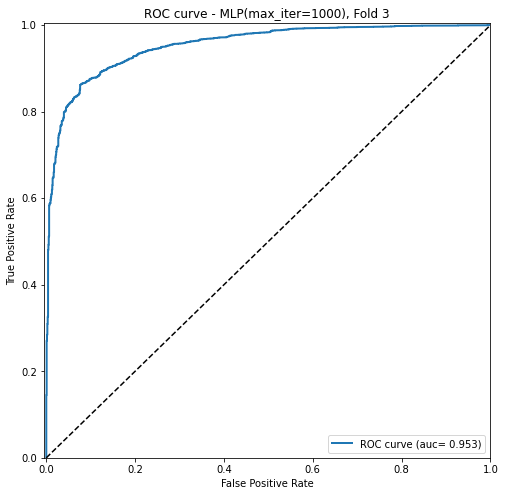

              precision    recall  f1-score   support

      benign       0.81      0.63      0.71      1238
   malicious       0.91      0.96      0.93      4588

    accuracy                           0.89      5826
   macro avg       0.86      0.80      0.82      5826
weighted avg       0.89      0.89      0.88      5826

Fit Time: 24.47042751312256 seconds



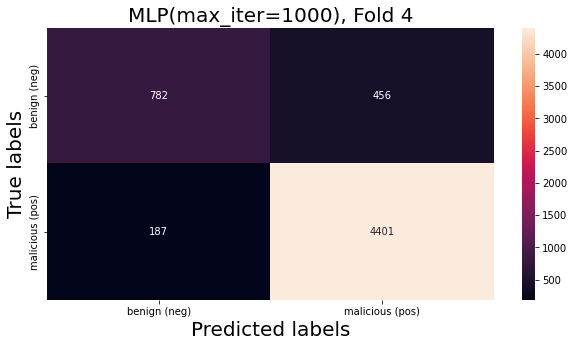

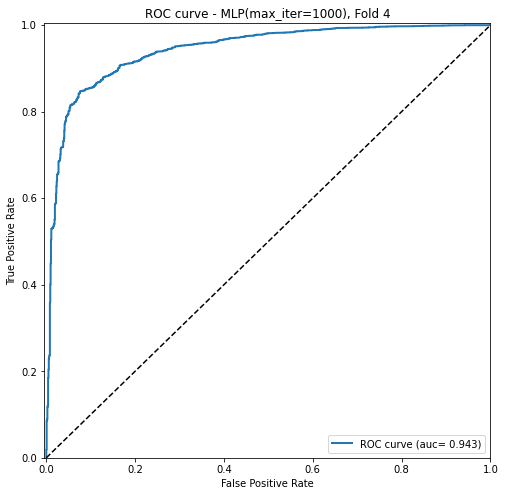

              precision    recall  f1-score   support

      benign       0.79      0.74      0.76      1243
   malicious       0.93      0.94      0.94      4583

    accuracy                           0.90      5826
   macro avg       0.86      0.84      0.85      5826
weighted avg       0.90      0.90      0.90      5826

Fit Time: 34.11461400985718 seconds



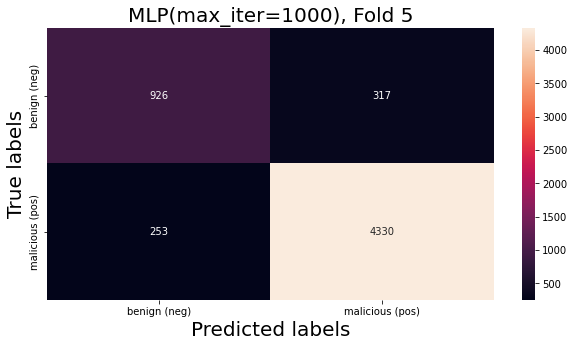

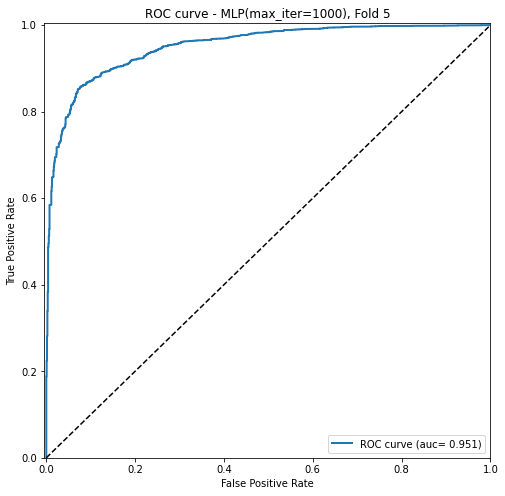

In [32]:
kf = KFold(n_splits=5)
i = 1

for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]
  Y_train, Y_test = Y[train_index], Y[test_index]

  model_name = f"mlp_{epocs}_fold_{i}"
  title = f"MLP(max_iter={epocs}), Fold {i}"
  classifier = MLPClassifier(random_state=5, max_iter=epocs)

  result = generate_classification_result(classifier, model_name, X_train, X_test, Y_train, Y_test)
  model_dict[model_name] = result
  model_dict[model_name]['title'] = title

  print("Fit Time:", result['fit_time'], 'seconds\n')
  confusion_matrix_grap(
    cm=result['confusion_matrix'], 
    title=title
  )

  plot_roc_curve(
      fpr=result['roc_curve']['fpr'],
      tpr=result['roc_curve']['tpr'],
      label="ROC curve (auc= %0.3f)" % result['roc_curve']['auc'],
      title=f"ROC curve - {title}"
  )
  i +=1

# Results

In [33]:
for key in model_dict:
  print(key)

knn_1_80_20
knn_1_50_50
knn_1_fold_1
knn_1_fold_2
knn_1_fold_3
knn_1_fold_4
knn_1_fold_5
rf_50_80_20
rf_50_50_50
rf_50_fold_1
rf_50_fold_2
rf_50_fold_3
rf_50_fold_4
rf_50_fold_5
mlp_1000_80_20
mlp_1000_50_50
mlp_1000_fold_1
mlp_1000_fold_2
mlp_1000_fold_3
mlp_1000_fold_4
mlp_1000_fold_5


## ROC curves

### KNN

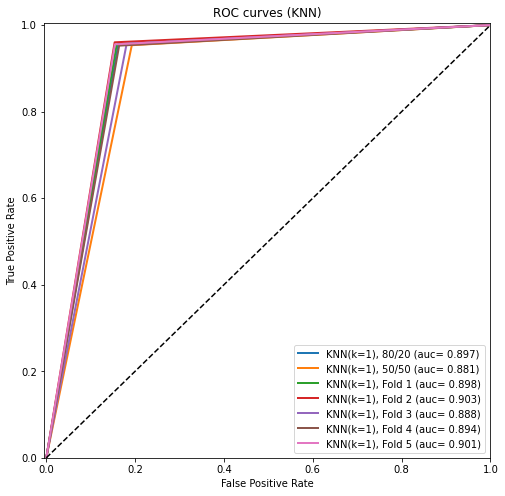

In [34]:
model_info = [
    model_dict[f"knn_{k}_80_20"],
    model_dict[f"knn_{k}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"knn_{k}_fold_{i}"])
  i+= 1

plt.figure(figsize=(8,8))
plt.title('ROC curves (KNN)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.savefig(os.path.join(IMAGES_PATH, "knn_roc.png"))
plt.show()

### RandomForest

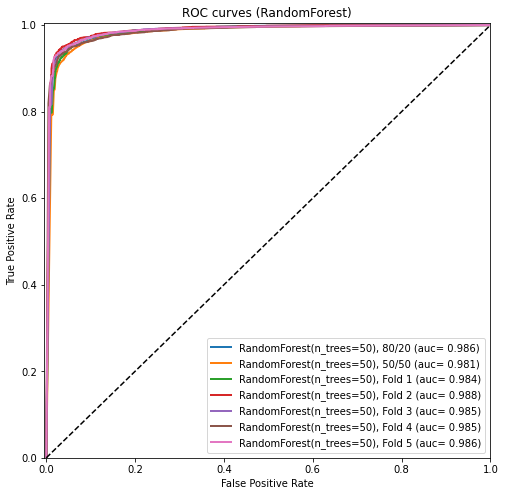

In [35]:
model_info = [
    model_dict[f"rf_{n_trees}_80_20"],
    model_dict[f"rf_{n_trees}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"rf_{n_trees}_fold_{i}"])
  i+= 1

plt.figure(figsize=(8,8))
plt.title('ROC curves (RandomForest)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.savefig(os.path.join(IMAGES_PATH, "rf_roc.png"))
plt.show()

### MLP

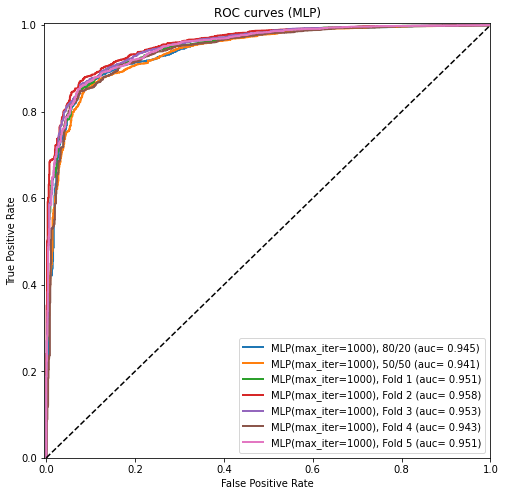

In [36]:
model_info = [
    model_dict[f"mlp_{epocs}_80_20"],
    model_dict[f"mlp_{epocs}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"mlp_{epocs}_fold_{i}"])
  i+= 1

plt.figure(figsize=(8,8))
plt.title('ROC curves (MLP)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.savefig(os.path.join(IMAGES_PATH, "mlp_roc.png"))
plt.show()

## Metrics Table

- Functions to color cells based on max/min value

In [37]:
def maximum_value_in_column(column, color='palegreen'):    

    highlight = f"background-color: {color};"
    default = ''

    maximum_in_column = column.max()

    # must return one string per cell in this column
    return [highlight if v == maximum_in_column else default for v in column]

def minimum_value_in_column(column, color='red'):    

    highlight = f"background-color: {color};"
    default = ''

    maximum_in_column = column.min()

    # must return one string per cell in this column
    return [highlight if v == maximum_in_column else default for v in column]

### Create dataframe with metrics

In [38]:
model_list = []

headers = ['classifier', 'accuracy', 'precision', 'recall', 'f1-score', 'fit_time']

for key, value in model_dict.items():
  model_list.append(
      [
        value['title'],
        value['classification_report']['accuracy'],
        value['classification_report']['macro avg']['precision'],
        value['classification_report']['macro avg']['recall'],
        value['classification_report']['macro avg']['f1-score'],
        value['fit_time']
      ]
  )

df_metrics = pd.DataFrame(model_list, columns=headers)
df_metrics

,classifier,accuracy,precision,recall,f1-score,fit_time
0,"KNN(k=1), 80/20",0.930839,0.897705,0.897012,0.897358,0.043961
1,"KNN(k=1), 50/50",0.922221,0.886774,0.880506,0.883585,0.026628
2,"KNN(k=1), Fold 1",0.931354,0.894435,0.898257,0.896327,0.049317
3,"KNN(k=1), Fold 2",0.935130,0.906815,0.903144,0.904961,0.055274
4,"KNN(k=1), Fold 3",0.926720,0.894427,0.887804,0.891055,0.048658
5,"KNN(k=1), Fold 4",0.927738,0.890813,0.894255,0.892518,0.050014
6,"KNN(k=1), Fold 5",0.932029,0.897723,0.900511,0.899107,0.050552
7,"RandomForest(n_trees=50), 80/20",0.953321,0.933607,0.927008,0.930255,1.355263
8,"RandomForest(n_trees=50), 50/50",0.951054,0.929669,0.924128,0.926861,0.842649
9,"RandomForest(n_trees=50), Fold 1",0.956581,0.935589,0.932131,0.933846,1.334119


### Apply styles to best and worst values

In [39]:
df_metrics.style.apply(maximum_value_in_column, subset=['recall', 'precision', 'f1-score', 'accuracy'], axis=0, color='palegreen')\
  .apply(minimum_value_in_column, subset=['recall', 'precision', 'f1-score', 'accuracy'], axis=0, color='indianred')\
  .apply(maximum_value_in_column, subset=['fit_time'], axis=0, color='indianred')\
  .apply(minimum_value_in_column, subset=['fit_time'], axis=0, color='palegreen')

,classifier,accuracy,precision,recall,f1-score,fit_time
0,"KNN(k=1), 80/20",0.930839,0.897705,0.897012,0.897358,0.043961
1,"KNN(k=1), 50/50",0.922221,0.886774,0.880506,0.883585,0.026628
2,"KNN(k=1), Fold 1",0.931354,0.894435,0.898257,0.896327,0.049317
3,"KNN(k=1), Fold 2",0.935130,0.906815,0.903144,0.904961,0.055274
4,"KNN(k=1), Fold 3",0.926720,0.894427,0.887804,0.891055,0.048658
5,"KNN(k=1), Fold 4",0.927738,0.890813,0.894255,0.892518,0.050014
6,"KNN(k=1), Fold 5",0.932029,0.897723,0.900511,0.899107,0.050552
7,"RandomForest(n_trees=50), 80/20",0.953321,0.933607,0.927008,0.930255,1.355263
8,"RandomForest(n_trees=50), 50/50",0.951054,0.929669,0.924128,0.926861,0.842649
9,"RandomForest(n_trees=50), Fold 1",0.956581,0.935589,0.932131,0.933846,1.334119
